In [1]:
%load_ext autoreload
%autoreload 2

import constants_and_utils as cu
from vaccine_intent import *
from graph_methods import *

import csv
import matplotlib.pyplot as plt
import os
from scipy import sparse
from scipy.stats import pearsonr, linregress
import pickle
import geopandas as gpd

/home/t-sechang/env/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Overview
This notebook compares vaccine intent queries on Bing vs. Google.

In [ ]:
# get total num queries per state and month
# run this once; in the future, we just load it
level = 'State'
all_state_totals = None
for date_range in cu.DATE_RANGES[2:]:
    month = date_range.split('-')[1]
    print(date_range, month)
    fn = os.path.join(cu.PATH_TO_BING_DATA, 'us_ds_%s.tsv' % date_range)
    bing_df = pd.read_csv(fn, delimiter='\t', header=0, quoting=csv.QUOTE_NONE, on_bad_lines='skip')
    print('Loaded Bing user df, len =', len(bing_df))  
    mode_prop = bing_df['Max%sCount' % level] / bing_df['QueryCountWith%s' % level]
    kept_bing_df = bing_df[(bing_df['QueryCountWith%s' % level] >= 10) & (mode_prop >= 0.25)]
    print('Can assign %d (%.2f%%) active users to %s' % (len(kept_bing_df), 
                            100. * len(kept_bing_df) / len(bing_df), level))
    
    # approximate total number of queries per state
    # sum query count over active users assigned to state
    state_totals = kept_bing_df.groupby('MaxState').sum()['QueryCount'].rename('QueryCount_%s' % month)
    if all_state_totals is None:
        all_state_totals = state_totals
    else:
        all_state_totals = pd.merge(all_state_totals, state_totals, left_index=True, right_index=True, how='outer')
    print('Added count info for %d unique %ss' % (len(state_totals), level))

all_state_totals['Avg_QueryCount'] = np.mean(all_state_totals.values, axis=1)
all_state_totals.to_csv(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'query_counts_%s.csv' % level))  # need to save index

In [3]:
# get states and datetimes for study
states_df = pd.read_csv('../data/state_abbrs.csv')
print(len(states_df))
states = states_df.State.values
state2abbrs = dict(zip(states_df.State, states_df.Code))
datetimes = cu.get_datetimes_in_range(datetime.datetime(2021, 2, 1), datetime.datetime(2021, 8, 31))
print(len(datetimes))

51
212


In [ ]:
# load all vaccine intent queries
all_dfs = []
for date_range in cu.DATE_RANGES[2:]:
    month = date_range.split('-')[1]
    print(date_range, month)
    fn = os.path.join(cu.PATH_TO_BING_DATA, 'vaccine_intent_queries_%s.tsv' % date_range)
    query_df = pd.read_csv(fn, delimiter='\t', header=0, quoting=csv.QUOTE_NONE, on_bad_lines='skip')
    print('Loaded vaccine intent queries, len =', len(query_df))
    all_dfs.append(query_df)
all_dfs = pd.concat(all_dfs)
all_dfs['datetime'] = all_dfs.Request_RequestTime.apply(cu.extract_datetime)  # get day
all_dfs = all_dfs.sort_values(by='datetime')
all_dfs.head(10)

In [5]:
# check top 100 queries
query_counts = all_dfs.NormQuery.value_counts()
top_queries = query_counts.head(100)

In [7]:
# chose one per pharmacy and one per location-seeking
queries_to_test = ['cvs covid vaccine', 'rite aid covid vaccine', 
                   'walgreens covid vaccine', 'publix covid vaccine', 
                   'walmart covid vaccine', 'kroger covid vaccine', 
                   'giant eagle covid vaccine', 'safeway covid vaccine',
                   'heb covid vaccine', 'hyvee covid vaccine', 'costco covid vaccine',
                   'meijer covid vaccine', 'wegmans covid vaccine', 'shoprite covid vaccine',
                   'winn dixie covid vaccine', 'jewel osco covid vaccine', 'king soopers covid vaccine',
                   'stop and shop covid vaccine', 'albertsons covid vaccine',
                   'covid vaccine near me', 'covid vaccine appointment', 'covid vaccine locations',
                   'covid vaccine finder', 'where to get covid vaccine', 'covid vaccine registration',
                   'covid vaccine sign up', 'schedule covid vaccine', 'register for covid vaccine',
                   'where can i get a covid vaccine', 'sign up for covid vaccine']
print(len(queries_to_test))
assert all([q in top_queries.index for q in queries_to_test])

30


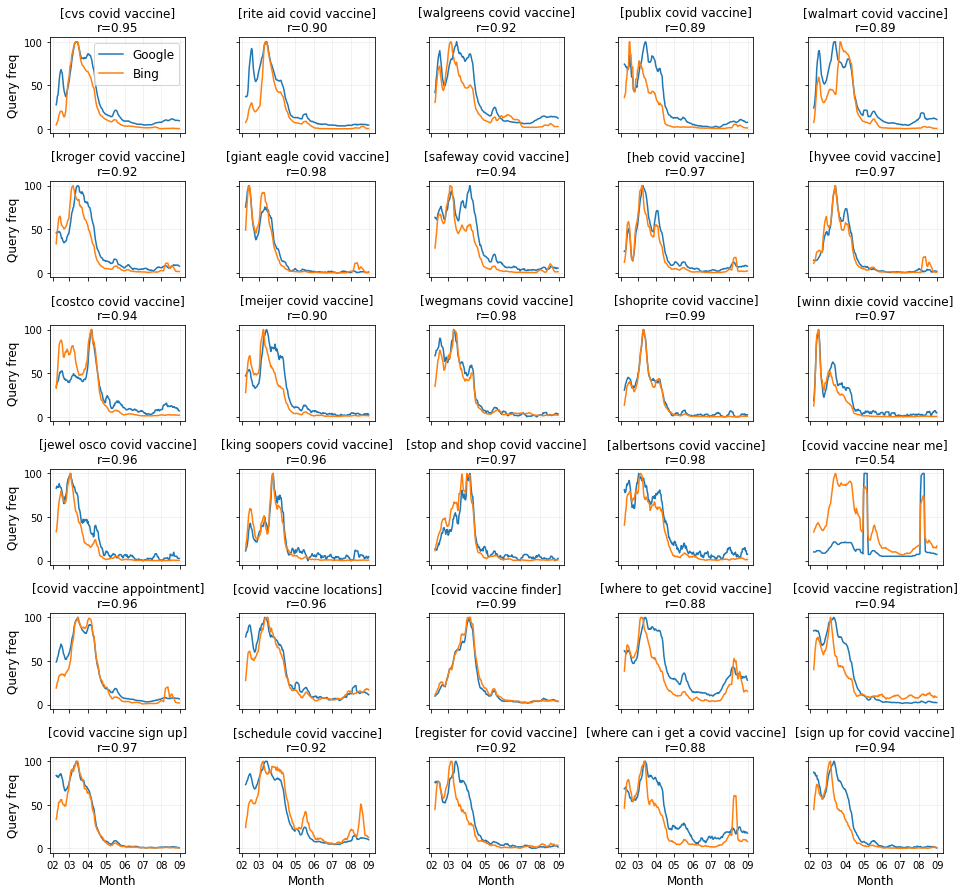

In [9]:
# correlations over time
correlations = []
fig, axes = plt.subplots(6, 5, figsize=(16, 15), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.4, hspace=0.5)
axes = axes.flatten()
assert len(axes) == len(queries_to_test)
for i in range(len(axes)):
    ax, query = axes[i], queries_to_test[i]
    r, _, _ = compare_query_timeseries_bing_vs_google(query, datetimes, all_dfs, smooth_days=7, 
                                                      ax=ax, set_labels=False, verbose=False)
    correlations.append({'query': query, 'corr': r})
    if i == 0:
        ax.legend(fontsize=12)
    if (i % 5) == 0:
        ax.set_ylabel('Query freq', fontsize=12)
    if i >= 25:
        ax.set_xlabel('Month', fontsize=12)
plt.savefig(os.path.join(PATH_TO_RESULTS, 'google_vs_bing_query_over_time.pdf'), bbox_inches='tight')

In [10]:
correlations = pd.DataFrame(correlations, columns=['query', 'corr'])
correlations[['corr']].describe(percentiles=[0.025, 0.05, 0.25, 0.75, 0.95, 0.975]).round(4)

,corr
count,30.0000
mean,0.9297
std,0.0816
min,0.5357
2.5%,0.7862
5%,0.8813
25%,0.9166
50%,0.9454
75%,0.9685
95%,0.9880


[cvs covid vaccine]: computing over 51 states
[rite aid covid vaccine]: computing over 41 states
[walgreens covid vaccine]: computing over 51 states
[publix covid vaccine]: computing over 36 states
[walmart covid vaccine]: computing over 51 states
[kroger covid vaccine]: computing over 38 states
[giant eagle covid vaccine]: computing over 21 states
[safeway covid vaccine]: computing over 31 states
[heb covid vaccine]: computing over 19 states
[hyvee covid vaccine]: computing over 19 states
[costco covid vaccine]: computing over 39 states
[meijer covid vaccine]: computing over 19 states
[wegmans covid vaccine]: computing over 12 states
[shoprite covid vaccine]: computing over 10 states
[winn dixie covid vaccine]: computing over 16 states
[jewel osco covid vaccine]: computing over 11 states
[king soopers covid vaccine]: computing over 3 states
[stop and shop covid vaccine]: computing over 12 states
[albertsons covid vaccine]: computing over 21 states
[covid vaccine near me]: computing ov

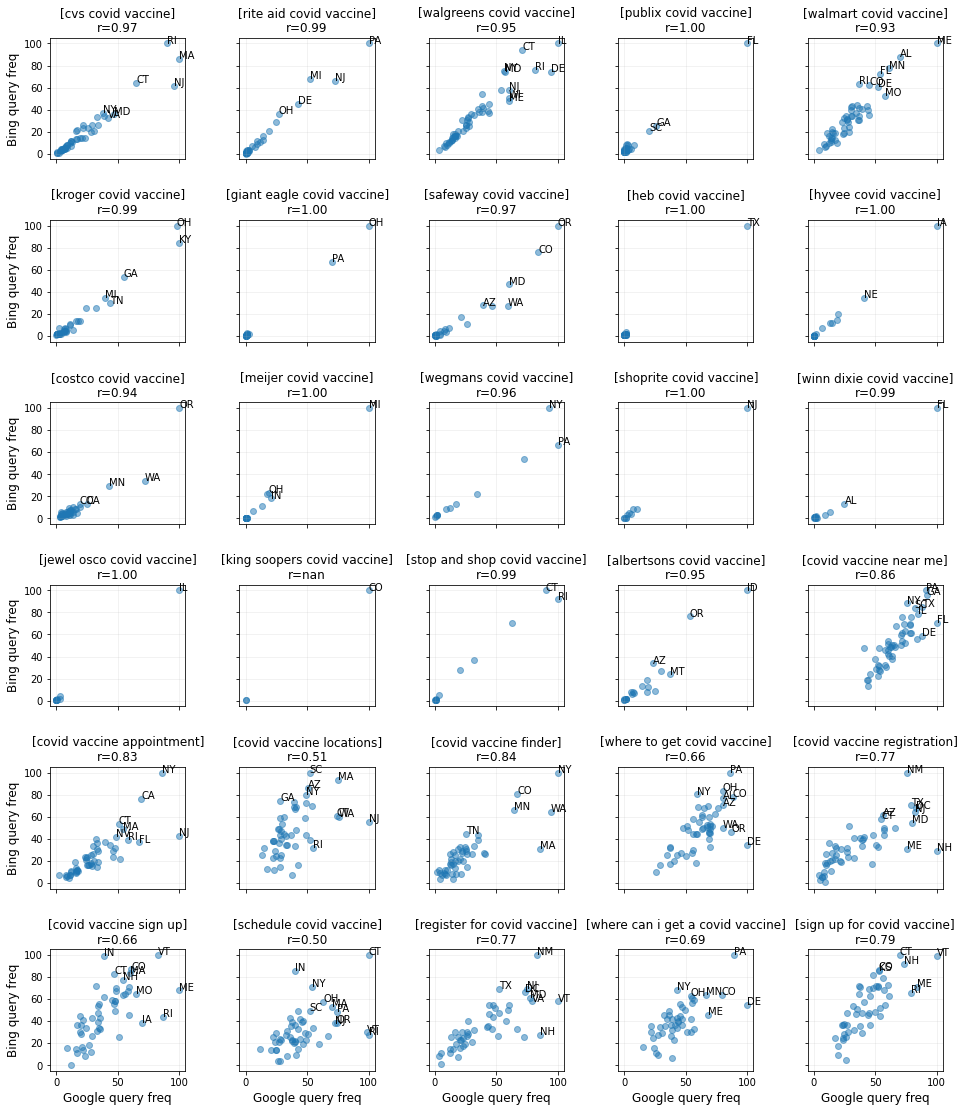

In [11]:
# correlations over states
geo_correlations = []
fig, axes = plt.subplots(6, 5, figsize=(16, 19), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.4, hspace=0.5)
axes = axes.flatten()
assert len(axes) == len(queries_to_test)
for i in range(len(axes)):
    ax, query = axes[i], queries_to_test[i]
    r, _, _ = compare_query_over_states_bing_vs_google(query, states, all_dfs, all_state_totals.Avg_QueryCount, state2abbr=state2abbrs, 
                                         ax=ax, set_labels=False, verbose=False)
    geo_correlations.append({'query': query, 'corr': r})
    if (i % 5) == 0:
        ax.set_ylabel('Bing query freq', fontsize=12)
    if i >= 25:
        ax.set_xlabel('Google query freq', fontsize=12)
plt.savefig(os.path.join(PATH_TO_RESULTS, 'google_vs_bing_query_over_states.pdf'), bbox_inches='tight')

In [12]:
geo_correlations = pd.DataFrame(geo_correlations, columns=['query', 'corr'])
geo_correlations[['corr']].describe(percentiles=[0.025, 0.05, 0.25, 0.75, 0.95, 0.975]).round(4)

,corr
count,29.0000
mean,0.8800
std,0.1497
min,0.5024
2.5%,0.5104
5%,0.5725
25%,0.7865
50%,0.9522
75%,0.9919
95%,0.9996
